# Questions 7 & 8

This script designs low pass Butterworth filters, of order varying from 4th to 8th, to meet a given specification. The script examines the stability of the filters and also the effects of 16-bit quantisation.

In [3]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from a2_config import A2_ROOT, SAVEFIG_CONFIG

In [2]:
# Define filter specifications

F_S = 30    # sampling frequency, kHz
F_C =  3    # cutoff frequency, kHz

In [45]:
# Define utility functions for displaying frequency response and pole-zero plots
import scipy.signal as signal
from matplotlib.patches import Circle

def plot_freqz(w, h, fname=None):
    """Plot frequency response and overlay filter requirements."""
    fig, axs = plt.subplots(2, sharex=True, figsize=(6, 3))
    fig.tight_layout()
    sns.lineplot(x=w, y=np.abs(h), ax=axs[0])
    sns.lineplot(x=w, y=np.angle(h), ax=axs[1])
    # Axis labels
    axs[0].set_ylabel("Gain")
    axs[1].set_xlabel("Frequency (kHz)")
    axs[1].set_ylabel("Phase (rad)")
    axs[1].set_yticks([-np.pi, 0, np.pi])
    axs[1].set_yticklabels(["$-\pi$", "0", "$\pi$"])
    # Save or just show
    if fname:
        fig.savefig(Path(A2_ROOT, "output", fname), **SAVEFIG_CONFIG)
    plt.show()

def zplane(b, a, fname=None):
    """Plot poles and zeros from numerator and denominator of transfer function."""
    z, p, _ = signal.tf2zpk(b, a)
    fig, ax = plt.subplots(figsize=(6, 5))
    fig.tight_layout()
    ax.set_aspect("equal")
    # Axes and unit circle
    ax.add_patch(Circle((0, 0), 1, fill=False, color="k", ls=":", lw=0.5))
    ax.autoscale()
    ax.axhline(0, c="k", ls=":", lw=0.5)
    ax.axvline(0, c="k", ls=":", lw=0.5)
    # Poles and zeros
    color = sns.color_palette()[0]
    sns.scatterplot(x=z.real, y=z.imag, ax=ax, marker="o", 
                    edgecolor=color, facecolor="none")
    sns.scatterplot(x=p.real, y=p.imag, ax=ax, marker="x", lw=2)
    # Axis labels
    ax.set_xlabel("Real")
    ax.set_ylabel("Imaginary")
    if fname:
        fig.savefig(Path(A2_ROOT, "output", fname), **SAVEFIG_CONFIG)
    plt.show()

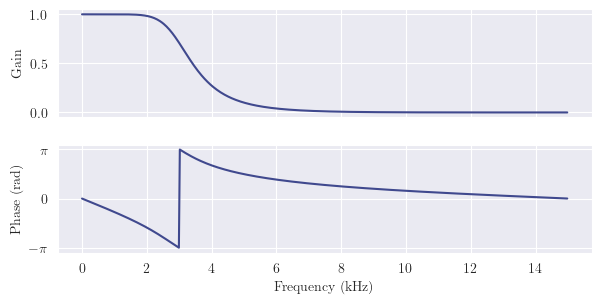

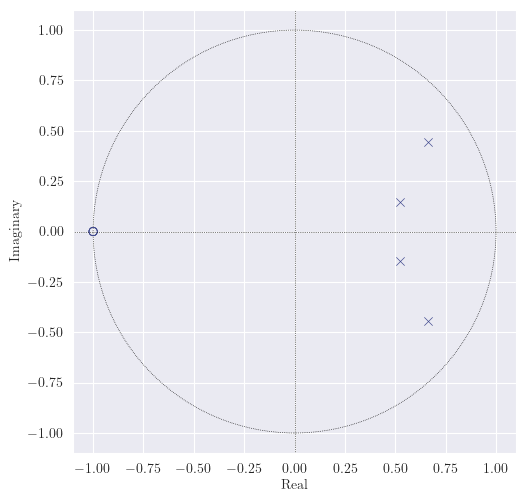

In [46]:
# Design 4th order Butterworth filter
b, a = signal.butter(4, F_C, btype="low", fs=F_S)
w, h = signal.freqz(b, a, fs=F_S)
plot_freqz(w, h)
zplane(b, a)

In [63]:
# Quantize the transfer function coefficients to 16 bits (15-bit mantissa)

def quantize(x):
    """Returns the given array quantised to 16 bits (15-bit mantissa)."""
    norm_factor = 0.5 / max(np.abs(x))
    xq = np.abs(x) * norm_factor + 0.5
    xq = np.round(xq * (2 << 15)) / (2 << 15)
    xq = np.sign(x) * (xq - 0.5) / norm_factor
    return xq

def tf_quantize(b, a):
    """Returns the given transfer function coefficients quantised to 16 bits."""
    return quantize(b), quantize(a)

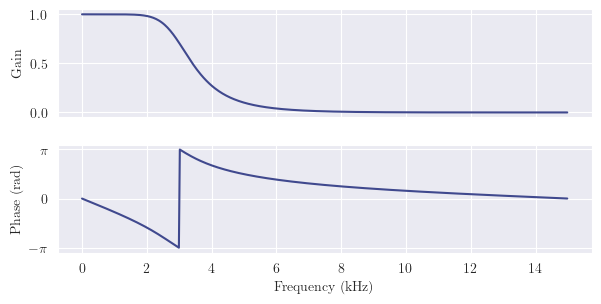

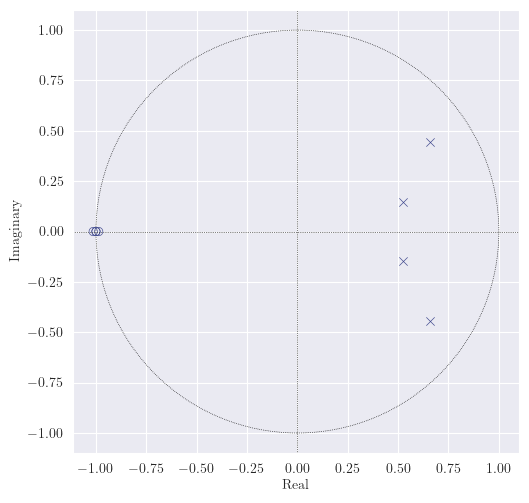

In [64]:
# Quantize coefficients of 4th-order filter and observe differences
bq, aq = tf_quantize(b, a)
wq, hq = signal.freqz(bq, aq, fs=F_S)
plot_freqz(wq, hq)
zplane(bq, aq)

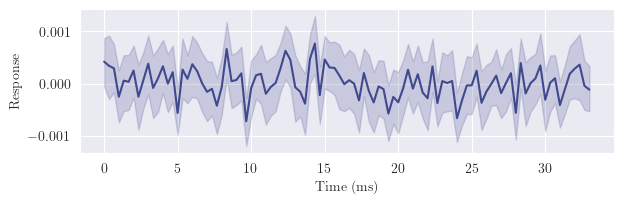

In [91]:
import pandas as pd

def test_filter(b, a, n_trials=10, fname=None):
    """
    Generates random uniformly-distributed sequences between [-0.5, 0.5) of 
    length 100 and applies the filter with the given coefficients. Plots the
    result to provide insight into filter stability.
    """
    t = np.linspace(0, 100/3, 100, endpoint=False)
    ones = np.ones(100)
    agg = []
    for i in range(n_trials):
        z = signal.lfilter(b, a, np.random.rand(100, 1) - 0.5).reshape(100)
        agg.append(np.array([t, ones * i, z]))
    agg = pd.DataFrame(np.hstack(agg).T, columns=["Time", "Trial", "Value"])
    fig, ax = plt.subplots(figsize=(6, 2))
    fig.tight_layout()
    sns.lineplot(data=agg, x="Time", y="Value")
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Response")
    if fname:
        fig.savefig(Path(A2_ROOT, "output", fname), **SAVEFIG_CONFIG)
    plt.show()

# Test the filter on several zero-mean random sequences and plot the outputs
test_filter(bq, aq, n_trials=25, fname="q7_4th_stability.png")